# Importing Necessary files

In [ ]:
%%capture
!pip install pennylane

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math.utils import requires_grad
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Reading the dataset and processing it

In [ ]:
# Reading the data

iris_data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Class']

data =  pd.read_csv(iris_data_url, names=column_names)
print(f'Size of the dataset: {data.shape}')
data.head()

Size of the dataset: (150, 5)


,Sepal Length,Sepal Width,Petal Length,Petal Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# Removing data for one class to convert this Multiclass classification problem to Binary classification problem

print(f'Before Removing data:\nShape of the dataset: {data.shape}')
print(data['Class'].value_counts())

data = data[data['Class']!='Iris-versicolor']

print(f'\nAfter Removing data:\nShape of the dataset: {data.shape}')
print(data['Class'].value_counts())

Before Removing data:
Shape of the dataset: (150, 5)
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Class, dtype: int64

After Removing data:
Shape of the dataset: (100, 5)
Iris-setosa       50
Iris-virginica    50
Name: Class, dtype: int64


In [ ]:
# Transforming the data from Pandas DataFrame to PennyLane Tensor

data = np.array(data.to_numpy())
print(data[:3])

[[tensor(5.1, requires_grad=True) tensor(3.5, requires_grad=True)
  tensor(1.4, requires_grad=True) tensor(0.2, requires_grad=True)
  tensor('Iris-setosa', dtype='<U11', requires_grad=True)]
 [tensor(4.9, requires_grad=True) tensor(3., requires_grad=True)
  tensor(1.4, requires_grad=True) tensor(0.2, requires_grad=True)
  tensor('Iris-setosa', dtype='<U11', requires_grad=True)]
 [tensor(4.7, requires_grad=True) tensor(3.2, requires_grad=True)
  tensor(1.3, requires_grad=True) tensor(0.2, requires_grad=True)
  tensor('Iris-setosa', dtype='<U11', requires_grad=True)]]


In [ ]:
# Splitting the data into features (X) and labels (y)

X = data[:, :-1]
y = data[:, -1]

print(f'Shape of features  : {X.shape}')
print(f'Shape of the labels: {y.shape}')

Shape of features  : (100, 4)
Shape of the labels: (100,)


In [ ]:
# Binarize the labels, y 

print(f'Unique values before binarizing: {set(y)}')

for i in range(len(y)):
    if y[i]=='Iris-setosa':
        y[i] = 1
    else:
        y[i] = -1

print(f'Unique values before binarizing: {set(y)}')

Unique values before binarizing: {tensor('Iris-virginica', dtype='<U14', requires_grad=True), tensor('Iris-setosa', dtype='<U11', requires_grad=True)}
Unique values before binarizing: {tensor(-1, requires_grad=True), tensor(1, requires_grad=True)}


# Some helper functions

In [ ]:
np.random.seed(0)
num_data = len(y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))

In [ ]:
def square_loss(labels, predictions):
    '''
    Function that calculates the square loss between true labels and predictions given by the model. Returns the average loss between them.
    @labels : The ground truth of the data
    @predictions : The predictions made by the model
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [ ]:
def accuracy(labels, predictions, threshold=1e-5):
    '''
    Function that calculates the accuracy of the model. If there is a difference of @threshold between the ground truth and predicted value, that is considered as correct.
    @labels : The ground truth of the data
    @predictions : The predictions made by the model
    @threshold : The value of tolerance that is accepted to label a prediction as correct. Default value is 1e-5.
    '''
    loss = 0
    for label, prediction in zip(labels, predictions):
        if abs(label - prediction) < threshold:
            loss = loss + 1
    loss = loss / len(labels)
    return loss

In [ ]:
def plot_graphs(title, cost_hist_adam, train_acc_hist_adam, val_acc_hist_adam, cost_hist_nesterov, train_acc_hist_nesterov, val_acc_hist_nesterov):
    '''
    Function that plots the history of the training for all ansatzes
    @title : String that mentions the title of the graph
    @cost_hist_adam : Dictionary containing the cost of ansatz during training with Adam optimizer
    @train_acc_hist_adam : Dictionary containing the training accuracy of ansatz during training with Adam optimizer
    @val_acc_hist_adam : Dictionary containing the validation accuracy of ansatz during training with Adam optimizer
    @cost_hist_nesterov : Dictionary containing the cost of ansatz during training with Nesterov optimizer
    @train_acc_hist_nesterov : Dictionary containing the training accuracy of ansatz during training with Nesterov optimizer
    @val_acc_hist_nesterov : Dictionary containing the validation accuracy of ansatz during training with Nesterov optimizer
    '''
    fig = plt.figure(figsize=(20,10))

    fig.suptitle(title, fontsize=20)
    for idx in range(1,4):
        plt.subplot(2, 3, idx)
        plt.plot(cost_hist_adam[idx], 'r', label='Training Loss')
        plt.plot(train_acc_hist_adam[idx], 'b', label='Training Accuracy')
        plt.plot(val_acc_hist_adam[idx], 'y', label='Validation Accuracy')
        plt.legend()
        plt.xlabel('Number of epochs')
        plt.title(f'Ansatze {idx} (Adam Optimizer)')
    
    for idx in range(1,4):
        plt.subplot(2, 3, idx+3)
        plt.plot(cost_hist_nesterov[idx], 'r', label='Training Loss')
        plt.plot(train_acc_hist_nesterov[idx], 'b', label='Training Accuracy')
        plt.plot(val_acc_hist_nesterov[idx], 'y', label='Validation Accuracy')
        plt.legend()
        plt.xlabel('Number of epochs')
        plt.title(f'Ansatze {idx} (Nasterov Optimizer)')

    plt.show()

# Amplitude Encoding

In [ ]:
def train_model(classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, epochs=50, batch_size=5, opt=AdamOptimizer()):
    '''
    Function that trains the given @classifier on @feats_train and @y_train.
    @classifier : classifier that trains on the data
    @weights_init : initial weights that needs to be updated
    @bias_init : initial biases that needs to be updated
    @feats_train : training features that are fed into the model
    @y_train : training labels that are fed into the model
    @feats_val : validation features that are fed into the model
    @y_val : validation labels that are fed into the model
    @epochs : number of epochs that are run (Default = 50)
    @batch_size : batch size for the data (Default = 5)
    @opt : optimizer that minimizes the loss (Default = AdamOptimizer())
    '''
    cost_hist = []
    train_acc_hist = []
    val_acc_hist = []

    weights = weights_init
    bias = bias_init

    for it in range(epochs):
        batch_index = np.random.randint(0, len(y_train), (batch_size,))
        feats_train_batch = feats_train[batch_index]
        y_train_batch = y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, y_train_batch)
        predictions_train = [np.sign(classifier(weights, bias, f)) for f in feats_train]
        predictions_val = [np.sign(classifier(weights, bias, f)) for f in feats_val]
        acc_train = accuracy(y_train, predictions_train)
        acc_val = accuracy(y_val, predictions_val)

        cost_hist.append(cost(weights, bias, features, y))
        train_acc_hist.append(acc_train)
        val_acc_hist.append(acc_val)
        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(it + 1, cost_hist[-1], acc_train, acc_val)
        )
    
    return cost_hist, train_acc_hist, val_acc_hist

In [ ]:
# Normalizing the data

X = X.astype(float)
y = y.astype(float)
normalization = np.sqrt(np.sum(X**2, -1))
X_norm = (X.T / normalization).T

print(f'Shape of features: {X_norm.shape}')
print(f'Shape of targets: {y.shape}')

Shape of features: (100, 4)
Shape of targets: (100,)


In [ ]:
def get_angles(x):
    '''
    The input @x is transformed into angles for amplitude encoding which can be fed into the network.
    @x : The input that has to be converted.
    '''
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1/2, beta1/2, -beta0/2, beta0/2])

def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [ ]:
# Dictionaries for storing the history of training

cost_hist_adam = {}
train_acc_hist_adam = {}
val_acc_hist_adam = {}

cost_hist_nesterov = {}
train_acc_hist_nesterov = {}
val_acc_hist_nesterov = {}

## Ansatze 1 (Amplitude Encoding)

In [ ]:
# Creating a device with 2 Qubits

dev = qml.device("default.qubit", wires=2)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.MultiRZ(W[0, 0], wires=0)
    qml.ControlledPhaseShift(W[1, 1], wires=[0, 1])
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)

    qml.MultiControlledX(wires=[0, 1])

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[1], train_acc_hist_adam[1], val_acc_hist_adam[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[1], train_acc_hist_nesterov[1], val_acc_hist_nesterov[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 0.6866960 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     2 | Cost: 0.6233453 | Acc train: 0.5333333 | Acc validation: 0.4400000 
Iter:     3 | Cost: 0.5703877 | Acc train: 0.6133333 | Acc validation: 0.4800000 
Iter:     4 | Cost: 0.5252194 | Acc train: 0.8000000 | Acc validation: 0.7200000 
Iter:     5 | Cost: 0.4809133 | Acc train: 0.9333333 | Acc validation: 0.9200000 
Iter:     6 | Cost: 0.4403608 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     7 | Cost: 0.4050311 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     8 | Cost: 0.3759750 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     9 | Cost: 0.3579876 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    10 | Cost: 0.3442855 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    11 | Cost: 0.3368702 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    12 | Cost: 0.3364920 | Acc train: 1.0000000 | Acc validatio

## Ansatze 2 (Amplitude Encoding)

In [ ]:
# Creating a device with 2 Qubits

dev = qml.device("default.qubit", wires=2)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.CRX(W[0, 0], wires=[0, 1])
    qml.Rot(W[0, 0], W[1, 1], W[0, 2], wires=1)

    qml.CY(wires=[0, 1])
    qml.CZ(wires=[0, 1])

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[2], train_acc_hist_adam[2], val_acc_hist_adam[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[2], train_acc_hist_nesterov[2], val_acc_hist_nesterov[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 0.7242967 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     2 | Cost: 0.7222615 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     3 | Cost: 0.7170666 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     4 | Cost: 0.7112226 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     5 | Cost: 0.7043101 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     6 | Cost: 0.6970673 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     7 | Cost: 0.6885561 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     8 | Cost: 0.6795790 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     9 | Cost: 0.6707427 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 0.6620586 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 0.6530795 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 0.6443577 | Acc train: 0.5200000 | Acc validatio

## Ansatze 3 (Amplitude Encoding)

In [ ]:
# Creating a device with 2 Qubits

dev = qml.device("default.qubit", wires=2)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.RY(W[1, 1], wires=0)
    qml.U1(W[0, 2], wires=1)
    qml.IsingXX(W[0, 0], wires=[0, 1])

    qml.FlipSign([1, 0], wires=[0, 1])

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[3], train_acc_hist_adam[3], val_acc_hist_adam[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[3], train_acc_hist_nesterov[3], val_acc_hist_nesterov[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 0.6891827 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     2 | Cost: 0.6330053 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     3 | Cost: 0.5735600 | Acc train: 0.6000000 | Acc validation: 0.4800000 
Iter:     4 | Cost: 0.5113170 | Acc train: 0.8533333 | Acc validation: 0.7600000 
Iter:     5 | Cost: 0.4520619 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     6 | Cost: 0.4007624 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     7 | Cost: 0.3650152 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     8 | Cost: 0.3398084 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:     9 | Cost: 0.3231906 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    10 | Cost: 0.3183013 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    11 | Cost: 0.3223337 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    12 | Cost: 0.3316448 | Acc train: 1.0000000 | Acc validatio

## Results for Amplitude Encoding

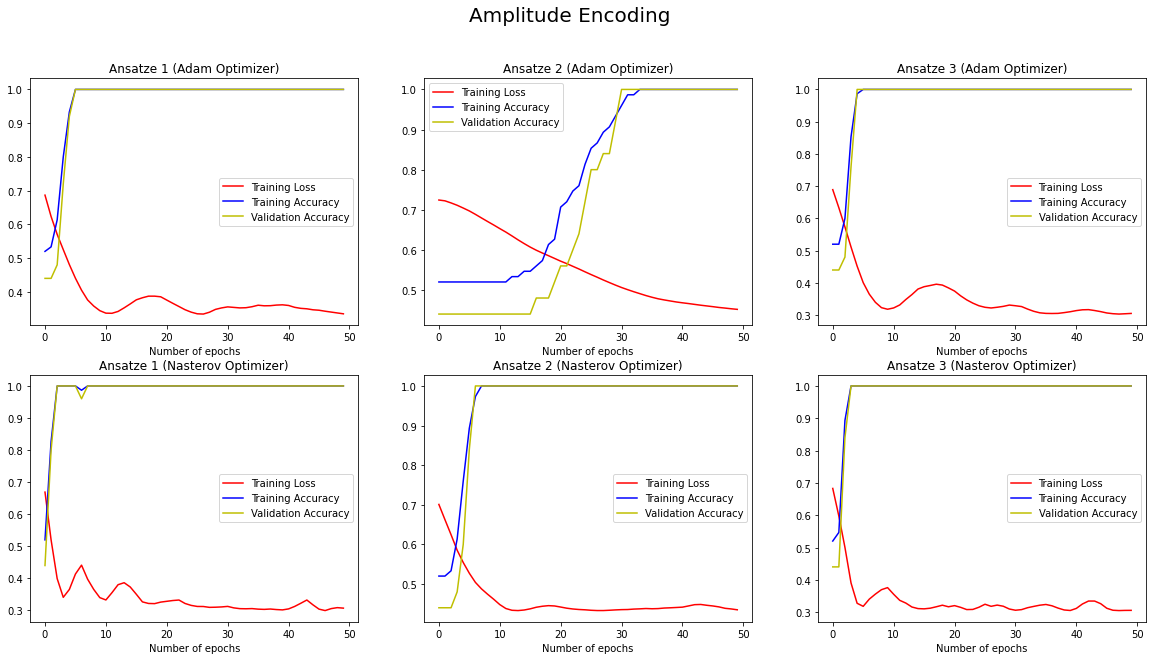

In [ ]:
# Plotting the losses of all models

plot_graphs('Amplitude Encoding', cost_hist_adam, train_acc_hist_adam, val_acc_hist_adam, cost_hist_nesterov, train_acc_hist_nesterov, val_acc_hist_nesterov)

# Rotational Encoding on X-axis

In [ ]:
def train_model(classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, epochs=50, batch_size=5, opt=AdamOptimizer()):
    '''
    Function that trains the given @classifier on @feats_train and @y_train.
    @classifier : classifier that trains on the data
    @weights_init : initial weights that needs to be updated
    @bias_init : initial biases that needs to be updated
    @feats_train : training features that are fed into the model
    @y_train : training labels that are fed into the model
    @feats_val : validation features that are fed into the model
    @y_val : validation labels that are fed into the model
    @epochs : number of epochs that are run (Default = 50)
    @batch_size : batch size for the data (Default = 5)
    @opt : optimizer that minimizes the loss (Default = AdamOptimizer())
    '''
    cost_hist = []
    train_acc_hist = []
    val_acc_hist = []

    weights = weights_init
    bias = bias_init

    for it in range(epochs):
        batch_index = np.random.randint(0, len(y_train), (batch_size,))
        feats_train_batch = feats_train[batch_index]
        y_train_batch = y_train[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, y_train_batch)
        predictions_train = [np.sign(classifier(weights, bias, f)) for f in feats_train]
        predictions_val = [np.sign(classifier(weights, bias, f)) for f in feats_val]
        acc_train = accuracy(y_train, predictions_train)
        acc_val = accuracy(y_val, predictions_val)

        cost_hist.append(cost(weights, bias, features, y))
        train_acc_hist.append(acc_train)
        val_acc_hist.append(acc_val)
        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(it + 1, cost_hist[-1], acc_train, acc_val)
        )
    
    return cost_hist, train_acc_hist, val_acc_hist

In [ ]:
# Normalizing the data (Smallest Val -> 0.0001, Biggest Val -> 2*pi)

def convert_col(idx):
    col = X[:, idx].copy()
    min_val = min(col)
    max_val = max(col)
    for i in range(len(col)):
        col[i] = (2 * math.pi - 0.0001) * (col[i] - min_val) / (max_val - min_val) + 0.0001
    return col

X_norm = X.copy()
for i in range(X.shape[-1]):
    X_norm[:, i] = convert_col(i)

print(f'Shape of features: {X_norm.shape}')
print(f'Shape of targets: {y.shape}')

Shape of features: (100, 4)
Shape of targets: (100,)


In [ ]:
# Dictionaries for storing the history of training

cost_hist_adam = {}
train_acc_hist_adam = {}
val_acc_hist_adam = {}

cost_hist_nesterov = {}
train_acc_hist_nesterov = {}
val_acc_hist_nesterov = {}

## Ansatze 1 (Rotational X Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.CRX(W[0, 0], wires=[0, 1])
    qml.CRY(W[1, 1], wires=[1, 2])
    qml.CRZ(W[2, 2], wires=[2, 3])
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RX(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[1], train_acc_hist_adam[1], val_acc_hist_adam[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[1], train_acc_hist_nesterov[1], val_acc_hist_nesterov[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 1.6523200 | Acc train: 0.4266667 | Acc validation: 0.3200000 
Iter:     2 | Cost: 1.6477855 | Acc train: 0.4266667 | Acc validation: 0.3200000 
Iter:     3 | Cost: 1.6400177 | Acc train: 0.4266667 | Acc validation: 0.3200000 
Iter:     4 | Cost: 1.6316176 | Acc train: 0.4133333 | Acc validation: 0.3200000 
Iter:     5 | Cost: 1.6223037 | Acc train: 0.3866667 | Acc validation: 0.3200000 
Iter:     6 | Cost: 1.6125001 | Acc train: 0.3600000 | Acc validation: 0.3200000 
Iter:     7 | Cost: 1.6025799 | Acc train: 0.3333333 | Acc validation: 0.3200000 
Iter:     8 | Cost: 1.5925549 | Acc train: 0.3200000 | Acc validation: 0.3600000 
Iter:     9 | Cost: 1.5816548 | Acc train: 0.3333333 | Acc validation: 0.3200000 
Iter:    10 | Cost: 1.5702259 | Acc train: 0.3200000 | Acc validation: 0.3600000 
Iter:    11 | Cost: 1.5587792 | Acc train: 0.3333333 | Acc validation: 0.3600000 
Iter:    12 | Cost: 1.5479610 | Acc train: 0.3333333 | Acc validatio

## Ansatze 2 (Rotational X Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.CRot(W[0, 0], W[0, 1], W[0, 2], wires=[0, 1])
    qml.SX(wires=1)
    qml.U2(W[2, 0], W[2, 1], wires=2)
    qml.U3(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.ECR(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.ECR(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RX(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[2], train_acc_hist_adam[2], val_acc_hist_adam[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[2], train_acc_hist_nesterov[2], val_acc_hist_nesterov[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer


/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Iter:     1 | Cost: 0.9631893 | Acc train: 0.6266667 | Acc validation: 0.5200000 
Iter:     2 | Cost: 0.9564460 | Acc train: 0.6266667 | Acc validation: 0.5200000 
Iter:     3 | Cost: 0.9470678 | Acc train: 0.6666667 | Acc validation: 0.5200000 
Iter:     4 | Cost: 0.9356119 | Acc train: 0.6666667 | Acc validation: 0.5200000 
Iter:     5 | Cost: 0.9220001 | Acc train: 0.6533333 | Acc validation: 0.5200000 
Iter:     6 | Cost: 0.9075634 | Acc train: 0.6533333 | Acc validation: 0.5200000 
Iter:     7 | Cost: 0.8907488 | Acc train: 0.6800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 0.8733623 | Acc train: 0.6933333 | Acc validation: 0.5600000 
Iter:     9 | Cost: 0.8536491 | Acc train: 0.7066667 | Acc validation: 0.5600000 
Iter:    10 | Cost: 0.8320909 | Acc train: 0.7066667 | Acc validation: 0.6000000 
Iter:    11 | Cost: 0.8078116 | Acc train: 0.7333333 | Acc validation: 0.7200000 
Iter:    12 | Cost: 0.7816195 | Acc train: 0.7466667 | Acc validation: 0.7200000 
Iter:    13 | Co

## Ansatze 3 (Rotational X Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.RY(W[0, 1], wires=0)
    qml.CRZ(W[1, 2], wires=[1, 2])
    qml.CRX(W[2, 0], wires=[2, 3])
    qml.CRY(W[3, 1], wires=[3, 0])

    qml.GroverOperator(wires=[0, 1, 2])
    qml.QubitCarry(wires=[0, 1, 2, 3])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RX(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[3], train_acc_hist_adam[3], val_acc_hist_adam[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[3], train_acc_hist_nesterov[3], val_acc_hist_nesterov[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 0.7856775 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     2 | Cost: 0.7789655 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     3 | Cost: 0.7711040 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     4 | Cost: 0.7624914 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     5 | Cost: 0.7533828 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     6 | Cost: 0.7436486 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     7 | Cost: 0.7338971 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     8 | Cost: 0.7239310 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     9 | Cost: 0.7137221 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:    10 | Cost: 0.7042431 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:    11 | Cost: 0.6955157 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:    12 | Cost: 0.6867084 | Acc train: 0.7466667 | Acc validatio

## Results for Rotational X Encoding

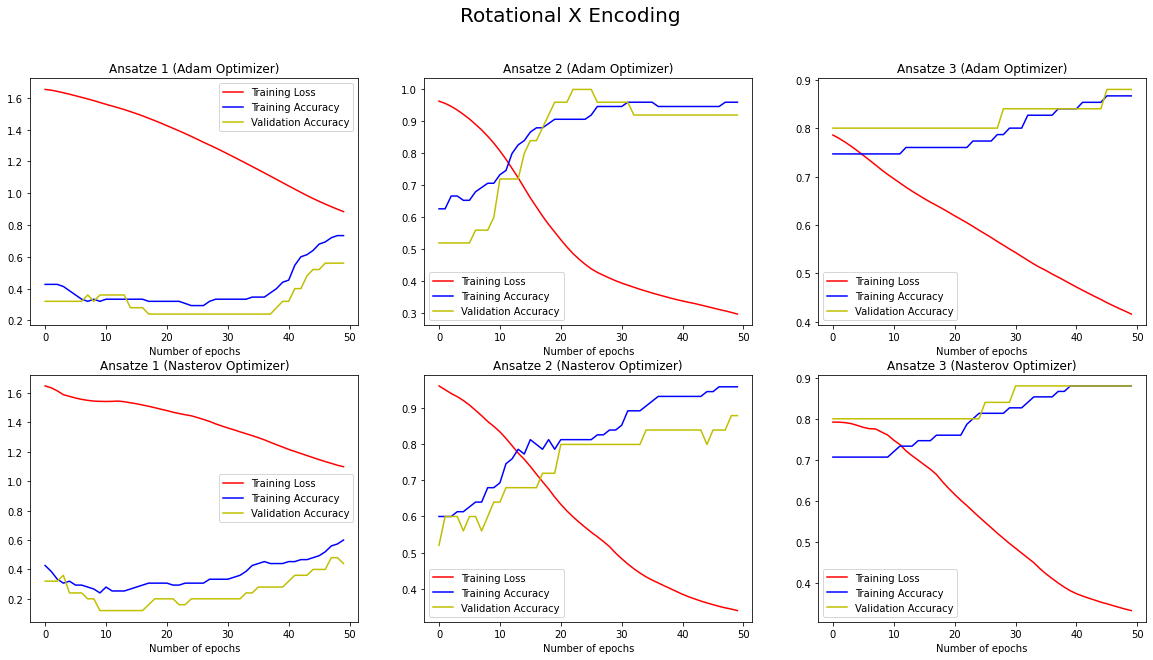

In [ ]:
# Plotting the losses of all models

plot_graphs('Rotational X Encoding', cost_hist_adam, train_acc_hist_adam, val_acc_hist_adam, cost_hist_nesterov, train_acc_hist_nesterov, val_acc_hist_nesterov)

# Rotational Encoding on Y-axis

In [ ]:
# Dictionaries for storing the history of training

cost_hist_adam = {}
train_acc_hist_adam = {}
val_acc_hist_adam = {}

cost_hist_nesterov = {}
train_acc_hist_nesterov = {}
val_acc_hist_nesterov = {}

## Ansatze 1 (Rotational Y Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.CRX(W[0, 0], wires=[0, 1])
    qml.CRY(W[1, 1], wires=[1, 2])
    qml.CRZ(W[2, 2], wires=[2, 3])
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RY(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[1], train_acc_hist_adam[1], val_acc_hist_adam[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[1], train_acc_hist_nesterov[1], val_acc_hist_nesterov[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 1.6412063 | Acc train: 0.4266667 | Acc validation: 0.3200000 
Iter:     2 | Cost: 1.6296178 | Acc train: 0.4266667 | Acc validation: 0.3200000 
Iter:     3 | Cost: 1.6133875 | Acc train: 0.4533333 | Acc validation: 0.3200000 
Iter:     4 | Cost: 1.5956157 | Acc train: 0.4533333 | Acc validation: 0.3200000 
Iter:     5 | Cost: 1.5766039 | Acc train: 0.4533333 | Acc validation: 0.3200000 
Iter:     6 | Cost: 1.5553572 | Acc train: 0.4533333 | Acc validation: 0.3200000 
Iter:     7 | Cost: 1.5318174 | Acc train: 0.4533333 | Acc validation: 0.3200000 
Iter:     8 | Cost: 1.5079680 | Acc train: 0.4533333 | Acc validation: 0.4000000 
Iter:     9 | Cost: 1.4821561 | Acc train: 0.4533333 | Acc validation: 0.4400000 
Iter:    10 | Cost: 1.4563481 | Acc train: 0.4533333 | Acc validation: 0.4400000 
Iter:    11 | Cost: 1.4280463 | Acc train: 0.4533333 | Acc validation: 0.4800000 
Iter:    12 | Cost: 1.3975422 | Acc train: 0.4666667 | Acc validatio

## Ansatze 2 (Rotational Y Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.CRot(W[0, 0], W[0, 1], W[0, 2], wires=[0, 1])
    qml.SX(wires=1)
    qml.U2(W[2, 0], W[2, 1], wires=2)
    qml.U3(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.ECR(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.ECR(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RY(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[2], train_acc_hist_adam[2], val_acc_hist_adam[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[2], train_acc_hist_nesterov[2], val_acc_hist_nesterov[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 1.0027560 | Acc train: 0.4666667 | Acc validation: 0.5600000 
Iter:     2 | Cost: 0.9879244 | Acc train: 0.6533333 | Acc validation: 0.7200000 
Iter:     3 | Cost: 0.9696696 | Acc train: 0.6400000 | Acc validation: 0.6800000 
Iter:     4 | Cost: 0.9523522 | Acc train: 0.6533333 | Acc validation: 0.6800000 
Iter:     5 | Cost: 0.9356477 | Acc train: 0.6800000 | Acc validation: 0.6400000 
Iter:     6 | Cost: 0.9214592 | Acc train: 0.6800000 | Acc validation: 0.6400000 
Iter:     7 | Cost: 0.9072596 | Acc train: 0.6933333 | Acc validation: 0.6800000 
Iter:     8 | Cost: 0.8907997 | Acc train: 0.7066667 | Acc validation: 0.7200000 
Iter:     9 | Cost: 0.8723706 | Acc train: 0.6933333 | Acc validation: 0.7200000 
Iter:    10 | Cost: 0.8532109 | Acc train: 0.6800000 | Acc validation: 0.6800000 
Iter:    11 | Cost: 0.8343333 | Acc train: 0.7066667 | Acc validation: 0.6800000 
Iter:    12 | Cost: 0.8158966 | Acc train: 0.7066667 | Acc validatio

## Ansatze 3 (Rotational Y Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.RY(W[0, 1], wires=0)
    qml.CRZ(W[1, 2], wires=[1, 2])
    qml.CRX(W[2, 0], wires=[2, 3])
    qml.CRY(W[3, 1], wires=[3, 0])

    qml.GroverOperator(wires=[0, 1, 2])
    qml.QubitCarry(wires=[0, 1, 2, 3])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RY(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[3], train_acc_hist_adam[3], val_acc_hist_adam[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[3], train_acc_hist_nesterov[3], val_acc_hist_nesterov[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 0.7601899 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     2 | Cost: 0.7245870 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     3 | Cost: 0.6888742 | Acc train: 0.7466667 | Acc validation: 0.8000000 
Iter:     4 | Cost: 0.6511083 | Acc train: 0.7600000 | Acc validation: 0.8000000 
Iter:     5 | Cost: 0.6163050 | Acc train: 0.7866667 | Acc validation: 0.8000000 
Iter:     6 | Cost: 0.5815756 | Acc train: 0.7866667 | Acc validation: 0.8000000 
Iter:     7 | Cost: 0.5481527 | Acc train: 0.8133333 | Acc validation: 0.8000000 
Iter:     8 | Cost: 0.5165930 | Acc train: 0.8266667 | Acc validation: 0.8400000 
Iter:     9 | Cost: 0.4885713 | Acc train: 0.8400000 | Acc validation: 0.8400000 
Iter:    10 | Cost: 0.4640717 | Acc train: 0.8533333 | Acc validation: 0.8800000 
Iter:    11 | Cost: 0.4428884 | Acc train: 0.8666667 | Acc validation: 0.8800000 
Iter:    12 | Cost: 0.4257663 | Acc train: 0.8800000 | Acc validatio

## Results for Rotational Y Encoding

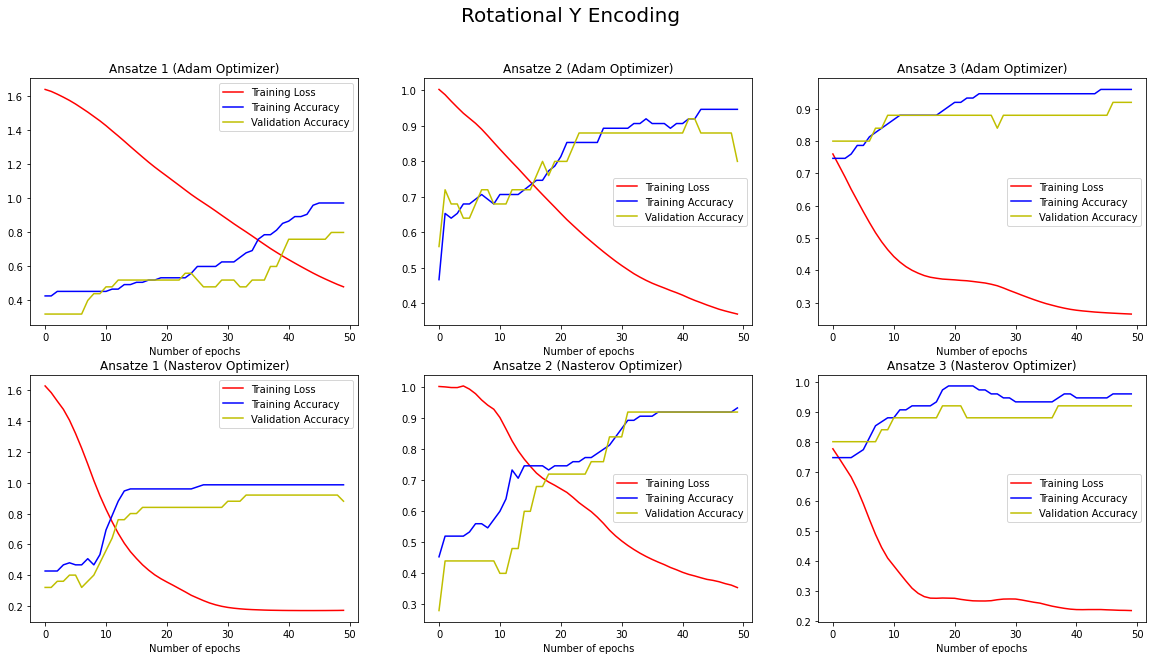

In [ ]:
# Plotting the losses of all models

plot_graphs('Rotational Y Encoding', cost_hist_adam, train_acc_hist_adam, val_acc_hist_adam, cost_hist_nesterov, train_acc_hist_nesterov, val_acc_hist_nesterov)

# Rotational Encoding on Z-axis

In [ ]:
# Dictionaries for storing the history of training

cost_hist_adam = {}
train_acc_hist_adam = {}
val_acc_hist_adam = {}

cost_hist_nesterov = {}
train_acc_hist_nesterov = {}
val_acc_hist_nesterov = {}

## Ansatze 1 (Rotational Z Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.CRX(W[0, 0], wires=[0, 1])
    qml.CRY(W[1, 1], wires=[1, 2])
    qml.CRZ(W[2, 2], wires=[2, 3])
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RZ(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[1], train_acc_hist_adam[1], val_acc_hist_adam[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[1], train_acc_hist_nesterov[1], val_acc_hist_nesterov[1] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 1.9953673 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     2 | Cost: 1.9850272 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     3 | Cost: 1.9718112 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     4 | Cost: 1.9580041 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     5 | Cost: 1.9419421 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     6 | Cost: 1.9240365 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     7 | Cost: 1.9032546 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     8 | Cost: 1.8802688 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     9 | Cost: 1.8568438 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 1.8319716 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 1.8060693 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 1.7818705 | Acc train: 0.5200000 | Acc validatio

## Ansatze 2 (Rotational Z Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.CRot(W[0, 0], W[0, 1], W[0, 2], wires=[0, 1])
    qml.SX(wires=1)
    qml.U2(W[2, 0], W[2, 1], wires=2)
    qml.U3(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.ECR(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.ECR(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RZ(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[2], train_acc_hist_adam[2], val_acc_hist_adam[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[2], train_acc_hist_nesterov[2], val_acc_hist_nesterov[2] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 1.0000675 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.0002202 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.0004157 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.0005823 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.0007784 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.0010032 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.0012555 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.0014727 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.0016458 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.0017697 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.0017714 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 1.0016572 | Acc train: 0.4800000 | Acc validatio

## Ansatze 3 (Rotational Z Encoding)

In [ ]:
# Creating a device with 4 Qubits

dev = qml.device("default.qubit", wires=4)

In [ ]:
def layer(W):
    '''
    Function that makes one layer for the model. Creates an arbitrary rotation on every Qubit and entangle them with their neighbours
    @W : The weights that are used for that layer
    '''
    qml.RY(W[0, 1], wires=0)
    qml.CRZ(W[1, 2], wires=[1, 2])
    qml.CRX(W[2, 0], wires=[2, 3])
    qml.CRY(W[3, 1], wires=[3, 0])

    qml.GroverOperator(wires=[0, 1, 2])
    qml.QubitCarry(wires=[0, 1, 2, 3])

In [ ]:
def statepreparation(a):
    '''
    Creates the states for the model given the angles @a
    @a : The angles for the input
    '''
    for i in range(4):
        qml.RZ(a[i], wires=i)

In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    '''
    Function that creates the circuit using the @weights and @angles and returns the expectation value
    @weights : The weights that are used to build layers in the circuit
    @angles : The angles of the input
    '''
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    '''
    Function that builds the circuits using @weights, @bias and @angles
    '''
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    '''
    Function that make predictions on the data and returns the square loss of the predictions.
    '''
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [ ]:
# Getting features and labels ready for training

features = np.array([x for x in X_norm], requires_grad=False)
feats_train = features[index[:num_train]]
y_train = y[index[:num_train]]
feats_val = features[index[num_train:]]
y_val = y[index[num_train:]]

In [ ]:
# Getting weights and biases for the model

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
# Training the model and storing the performance

print('Training using Adam optimizer')
cost_hist_adam[3], train_acc_hist_adam[3], val_acc_hist_adam[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val)

print('\nTraining using Nesterov optimizer')
cost_hist_nesterov[3], train_acc_hist_nesterov[3], val_acc_hist_nesterov[3] = train_model(variational_classifier, weights_init, bias_init, feats_train, y_train, feats_val, y_val, opt=NesterovMomentumOptimizer())

Training using Adam optimizer
Iter:     1 | Cost: 1.9931913 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     2 | Cost: 1.9866383 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     3 | Cost: 1.9764099 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     4 | Cost: 1.9617709 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     5 | Cost: 1.9445243 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     6 | Cost: 1.9249182 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     7 | Cost: 1.9019082 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     8 | Cost: 1.8767650 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     9 | Cost: 1.8467914 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 1.8127358 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 1.7753915 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 1.7360631 | Acc train: 0.5200000 | Acc validatio

## Results for Rotational Z Encoding

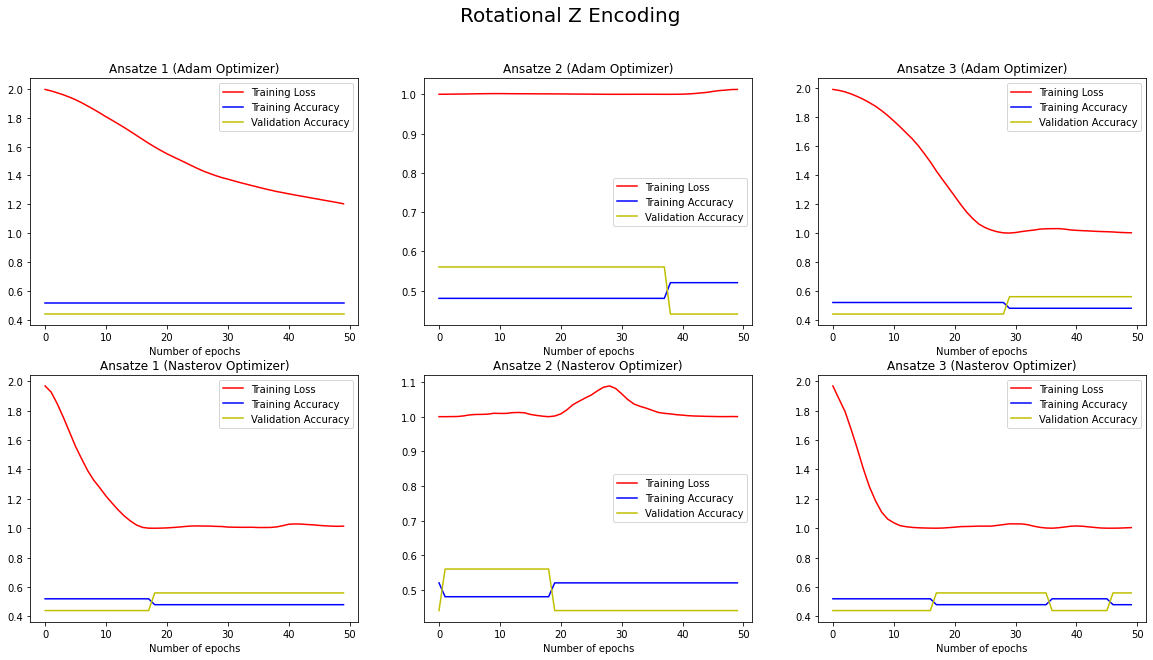

In [ ]:
# Plotting the losses of all models

plot_graphs('Rotational Z Encoding', cost_hist_adam, train_acc_hist_adam, val_acc_hist_adam, cost_hist_nesterov, train_acc_hist_nesterov, val_acc_hist_nesterov)

# Observations and Conclusions
There are three that I would like to write about

## Amplitude Embedding v/s Rotational Embedding
Before doing the assignment, I was expecting the rotational embeddings to outperform
the amplitude embeddings since it has more feature space to explore. But seeing the
results, it is evident that amplitude embedding works far better than the rotational
embedding on the Iris dataset (after removing one class). The following reasons may
explain why such a behavior is observed:

### A limited number of data points are available

Since only 100 data points are present in the dataset (out of which 25 were used
in validation), less number of qubits (2 in the case of amplitude encoding
compared to 4 in every rotational embedding) may lead to better learning. Since
amplitude embedding only needs a number of qubits, 𝑙𝑜𝑔(𝑛) there is a better
ratio of data points per qubit than rotational embeddings.

### Normalization used for data
I used the normalization method given in the pennylane documentation for
amplitude encoding. But for rotational embedding, I scaled the data between 0
and 2π. The method of normalization may also lead to some data loss. Although
upon discussing the results with the professor and my peers, I found that different
normalization methods for rotational embedding also lead to a similar result.
Further experimentation can shed some more light on the matter.

### Sheer luck in selecting Quantum Gates
Due to sheer luck, I may have chosen better quantum gates for the layers in the
case of amplitude embeddings than I did in rotational embeddings. Moreover, the
selected gates may be a poor choice for this particular dataset.

## Comparison between Rotational Embeddings
On comparing rotational embeddings it is evident that the following order is followed in terms of accuracy:

𝑋 − 𝑎𝑥𝑖𝑠 > 𝑌 − 𝑎𝑥𝑖𝑠 > 𝑍 − 𝑎𝑥𝑖𝑠

Since the same ansatzes and data points were used in all three rotational embeddings, it
is clear that rotational embedding on X-axis outperformed both Y and Z-axis
embeddings. The performance on Z-axis in particular was comparable to a random
guess (less than 60% accuracy). The following reasons may explain the above result:

### Nature of dataset chosen
Rotational Embedding converts the data that is given onto an axis (like a kernel
does in an SVM). The dataset that was given may be such that it was not
separable on the Z-axis. This may explain why the ansatzes were performing
poorly on the Z-axis.

### Sheer luck
Type of scaling that I did to the data and the choice of quantum gates that were
selected may also lead to such a result. However, upon discussing the results
obtained by other students and the professor, this situation is highly unlikely.

## Adam v/s Nesterov Momentum Optimizer
During the lectures, the professor repeatedly told us to use Adam optimizer. However
pennylane documentation uses Nesterov Momentum Optimizer. I trained my ansatzes
using both the above-mentioned optimizers and found that Nesterov Momentum
Optimizer converges earlier in most cases. This directly contradicts what the professor
was discussing in his lectures, so a further look into this is required.

## Overall, for me, ansatz 1 and 3 in amplitude embedding performed the best (especially using Nesterov Momentum Optimizer).